In [1]:
from netCDF4 import Dataset
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from datetime import datetime, timedelta
from scipy.stats import norm
import sys
from scipy.stats import gaussian_kde
from scipy.stats import uniform
sys.path.append(r'C:\Users\schijven\Documents\Classes\Input_preparation\lib')

C:\Users\schijven\AppData\Local\Temp\ipykernel_7156\278772668.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
%load_ext autoreload
%autoreload 2
from input_preparation_new import Input_prep

In [3]:
# all variables in a yaml file
config_filename=r"C:\Users\schijven\Documents\Data\config.yaml"

In [4]:
tg_vlis = pd.read_csv(Path(r"C:\Users\schijven\Documents\Data\vlissingen-vlissgn-nld-rwsHatyan.csv"))
tg_schev = pd.read_csv(Path(r"C:\Users\schijven\Documents\Data\scheveningen-schevngn-nld-rwsHatyan.csv"))
tg_eur = pd.read_csv(Path(r"C:\Users\schijven\Documents\Data\euro_platform-eurpfm-nld-rwsHatyan.csv"))

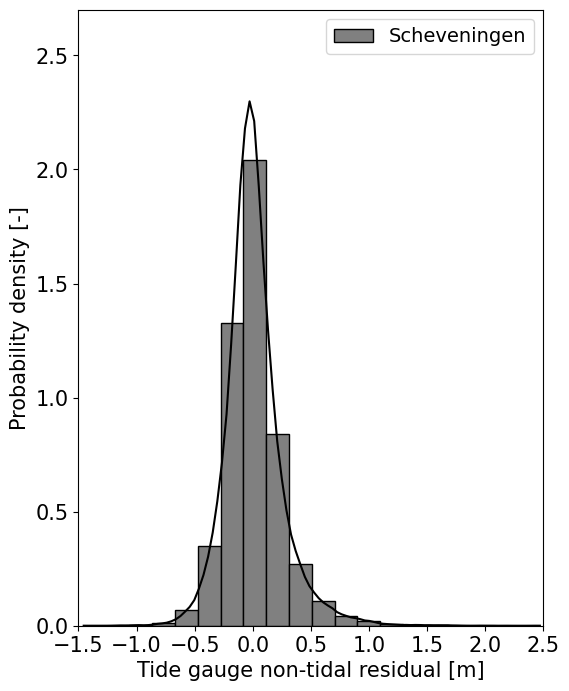

In [5]:
tg = tg_schev
tg = tg[(pd.to_datetime(tg.datetime) >= datetime(2001, 7, 1)) & (pd.to_datetime(tg.datetime) <= datetime(2018, 9, 7, 23))]
wl = tg.resid.dropna()
kde = gaussian_kde(wl)
x_values = np.linspace(min(wl), max(wl), 100)
pdf_values = kde(x_values)

plt.figure(figsize=(6,8))
plt.hist(wl, color="grey", edgecolor="k", bins=20, density=True, label="Scheveningen")
plt.plot(x_values, pdf_values, color="k")
plt.xlabel("Tide gauge non-tidal residual [m]", fontsize=15)
plt.ylabel("Probability density [-]", fontsize=15)
plt.legend(loc=1, fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0, 2.7)
plt.xlim(-1.5, 2.5)
plt.show()

In [6]:
data = np.load(Path(r"C:\Users\schijven\Documents\Data\Altimetry_full.npy"), allow_pickle=True)
data_df = pd.DataFrame(data, columns=['Time', 'MSS', 'MDT', 'bias', 'SLA', 'SSB', 'OT', 'ST', 'PT', 'DAC',
                   'SWH', 'sigma', 'lats', 'lons', 'udist_vlis', 'udist_schev', 'udist_eur', 'vdist_vlis', 'vdist_schev', 'vdist_eur',
                    'mission', 'track', 'cycle', 'geoid', 'DOT'])
data_df.drop(columns=["MSS", "MDT", "bias", "SLA", "SSB", "OT", "ST", "PT", "DAC", "SWH", "sigma",
                    "lats", "lons", "mission", "track", "cycle", "geoid"], inplace=True)

data_df = data_df[(data_df.Time >= datetime(2001, 7, 1) - timedelta(hours=48)) & (data_df.Time <= datetime(2018, 9, 7, 23) - timedelta(hours=1))]

In [7]:
t = data_df.Time
t_tg = pd.to_datetime(tg.datetime)
dt = []

t, t_tg
for i in tqdm(range(len(t_tg))):
    stop = pd.to_datetime(t_tg.values[i])
    start = pd.to_datetime(t_tg.values[i]) - timedelta(hours=48)
    t_alt = t[(pd.to_datetime(t.values) > start) & (pd.to_datetime(t.values) < stop)]
    dt_alt = (stop - t_alt).dt.total_seconds()
    dt.append(dt_alt.values)

100%|██████████| 150672/150672 [44:53<00:00, 55.94it/s]


Lower bound: 9.013888888888889e-07, Upper bound: 47.99999902638889


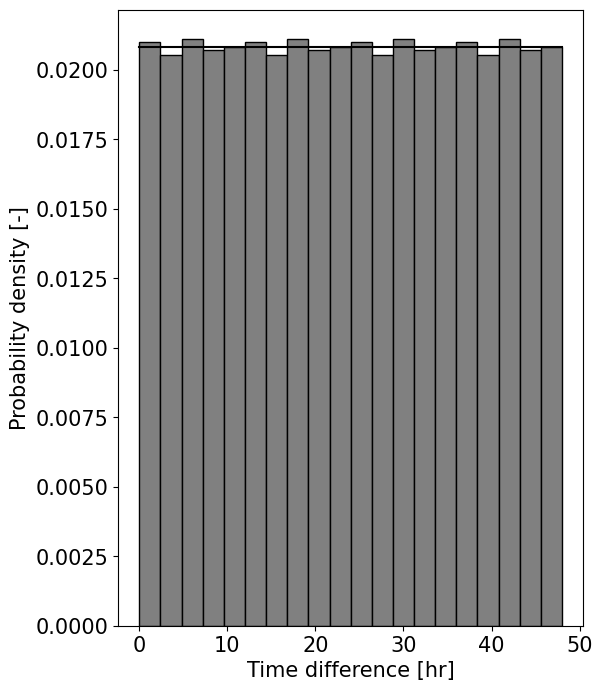

In [14]:
lower_bound, upper_bound = uniform.fit(np.concatenate(dt)/3600)

# Now you have the parameters of the fitted uniform distribution
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
x = np.linspace(lower_bound, upper_bound, 100)
pdf = uniform.pdf(x, loc=lower_bound, scale=upper_bound-lower_bound)

plt.figure(figsize=(6,8))
plt.hist(np.concatenate(dt)/3600, color="grey", edgecolor="k", bins=20, density=True)
plt.plot(x, pdf, color="k")
# plt.plot(x_values, pdf_values, color="k", label="PDF")
plt.xlabel("Time difference [hr]", fontsize=15)
plt.ylabel("Probability density [-]", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

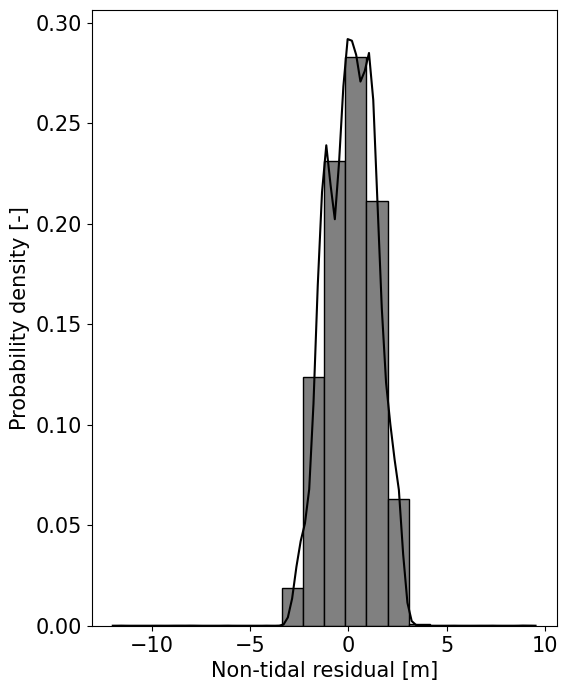

In [7]:
DOT_float = data_df.DOT.values.astype(float)
kde = gaussian_kde(DOT_float)
x_values = np.linspace(min(DOT_float), max(DOT_float), 100)
pdf_values = kde(x_values)

plt.figure(figsize=(6,8))
plt.hist(data_df.DOT, color="grey", edgecolor="k", bins=20, density=True)
plt.plot(x_values, pdf_values, color="k", label="PDF")
plt.xlabel("Non-tidal residual [m]", fontsize=15)
plt.ylabel("Probability density [-]", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

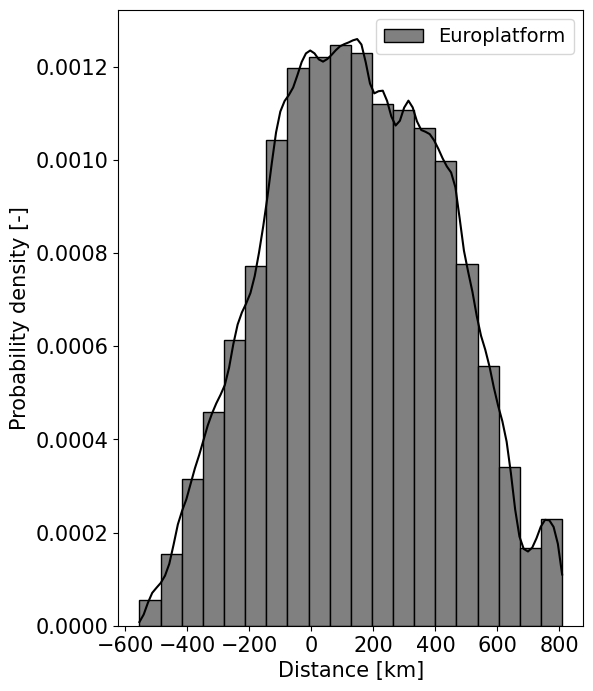

In [146]:
udist_float = data_df.udist_eur.values.astype(float)/1000
kde = gaussian_kde(udist_float)
x_values = np.linspace(min(udist_float), max(udist_float), 100)
pdf_values = kde(x_values)

plt.figure(figsize=(6,8))
# plt.hist(last_values_array, color="grey", edgecolor="k", bins=20, density=True)
plt.hist(udist_float, color="grey", edgecolor="k", bins=20, density=True, label="Europlatform")
# plt.hist(data_df.udist_schev/1000, color="grey", edgecolor="k", bins=20, density=True, label="Scheveningen")
# plt.hist(data_df.udist_eur/1000, color="grey", edgecolor="k", bins=20, density=True, label="Europlatform")
plt.plot(x_values, pdf_values, color="k")
plt.xlabel("Distance [km]", fontsize=15)
plt.legend(loc=1, fontsize=14)
plt.ylabel("Probability density [-]", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

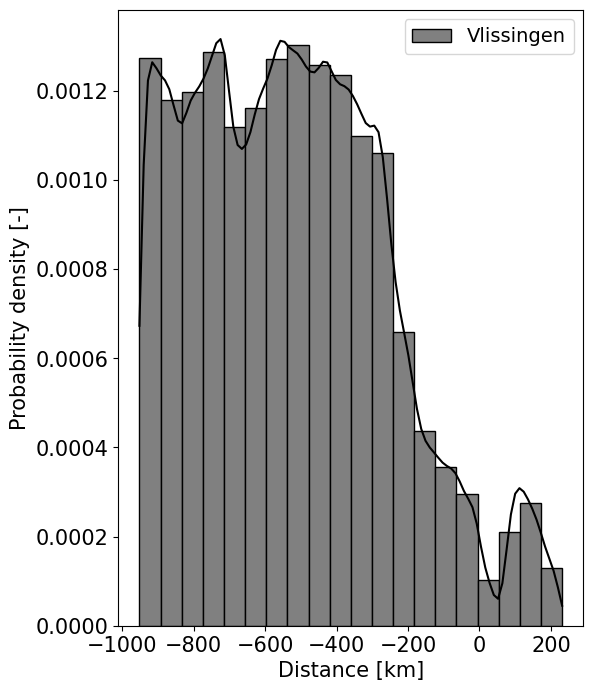

In [151]:
vdist_float = data_df.vdist_vlis.values.astype(float)/1000
kde = gaussian_kde(vdist_float)
x_values = np.linspace(min(vdist_float), max(vdist_float), 100)
pdf_values = kde(x_values)

plt.figure(figsize=(6,8))
plt.hist(vdist_float, color="grey", edgecolor="k", bins=20, density=True, label="Vlissingen")
# plt.hist(data_df.vdist_schev/1000, color="grey", edgecolor="k", bins=20, density=True, label="Scheveningen")
# plt.hist(data_df.vdist_eur/1000, color="grey", edgecolor="k", bins=20, density=True, label="Europlatform")
plt.plot(x_values, pdf_values, color="k")
plt.xlabel("Distance [km]", fontsize=15)
plt.legend(loc=1, fontsize=14)
plt.ylabel("Probability density [-]", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Lower bound: 1.0, Upper bound: 365.0


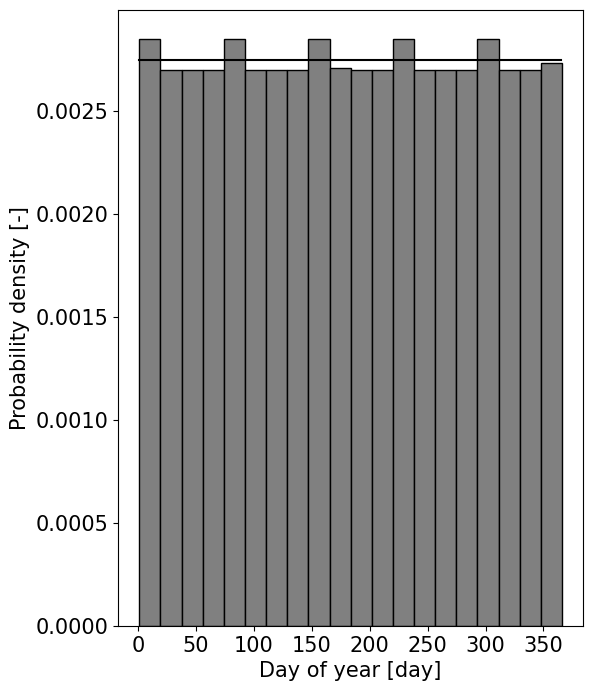

In [137]:
lower_bound, upper_bound = uniform.fit(dt.dayofyear.values.astype(float))

# Now you have the parameters of the fitted uniform distribution
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
x = np.linspace(lower_bound, upper_bound, 100)
pdf = uniform.pdf(x, loc=lower_bound, scale=upper_bound-lower_bound)

dt = pd.to_datetime(np.arange(datetime(2001, 7, 1), datetime(2018, 7, 1, 23), timedelta(hours=1)))
plt.figure(figsize=(6,8))
plt.hist(dt.dayofyear, color="grey", edgecolor="k", bins=20, density=True)
plt.plot(x, pdf, color="k")
plt.xlabel("Day of year [day]", fontsize=15)
plt.ylabel("Probability density [-]", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [57]:
data_era5 = np.load(Path(r"C:\Users\schijven\Documents\Data\ERA5_full.npy"))
start_date = pd.Timestamp("1900-01-01")
t_era5 = np.load(Path(r"C:\Users\schijven\Documents\Data\t_full.npy"))
t = pd.to_datetime(start_date) + pd.to_timedelta(np.concatenate(t_era5), unit="h")
t_clipped = t[(t >= datetime(2001, 7, 1) - timedelta(hours=48)) & (t <= datetime(2018, 7, 1, 23) - timedelta(hours=1))]
data_era5 = data_era5[(t >= datetime(2001, 7, 1) - timedelta(hours=48)) & (t <= datetime(2018, 7, 1, 23) - timedelta(hours=1))]

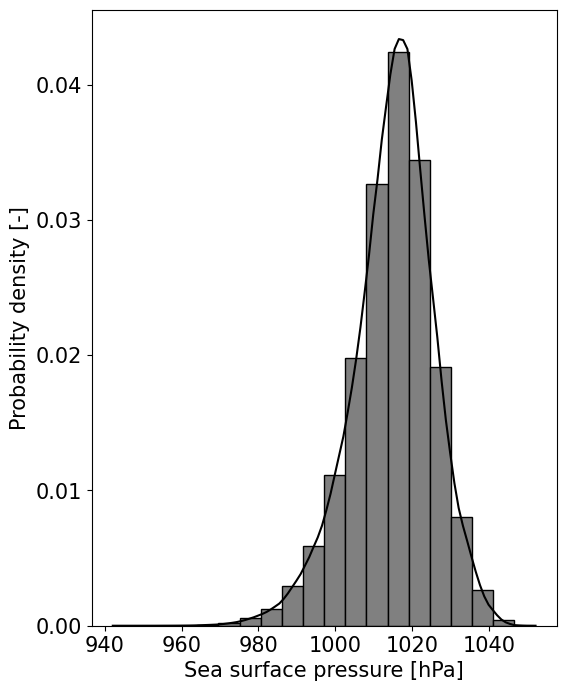

In [152]:
p = data_era5[:,:1498].flatten()/100
kde = gaussian_kde(p)
x_values = np.linspace(min(p), max(p), 100)
pdf_values = kde(x_values)

plt.figure(figsize=(6,8))
plt.hist(p, color="grey", edgecolor="k", bins=20, density=True)
plt.plot(x_values, pdf_values, color="k")
plt.xlabel("Sea surface pressure [hPa]", fontsize=15)
plt.ylabel("Probability density [-]", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

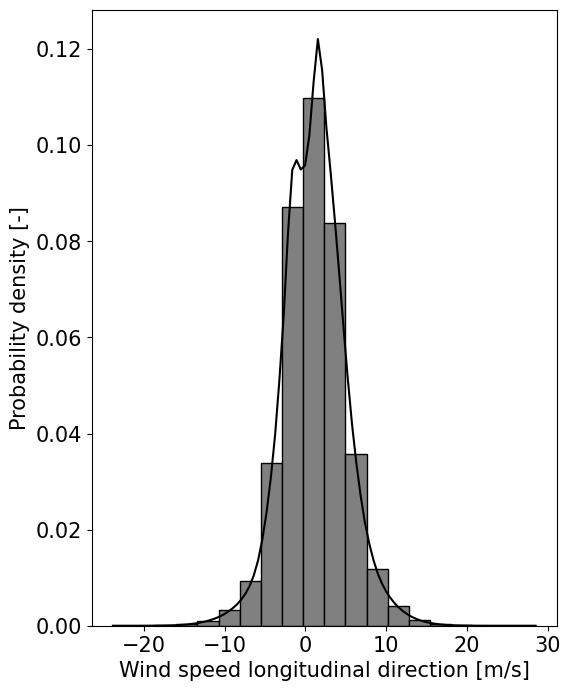

In [155]:
u10 = data_era5[:,1498:2*1498].flatten()
kde = gaussian_kde(u10)
x_values = np.linspace(min(u10), max(u10), 100)
pdf_values = kde(x_values)

plt.figure(figsize=(6,8))
plt.hist(u10, color="grey", edgecolor="k", bins=20, density=True)
plt.plot(x_values, pdf_values, color="k")
plt.xlabel("Wind speed longitudinal direction [m/s]", fontsize=15)
plt.ylabel("Probability density [-]", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

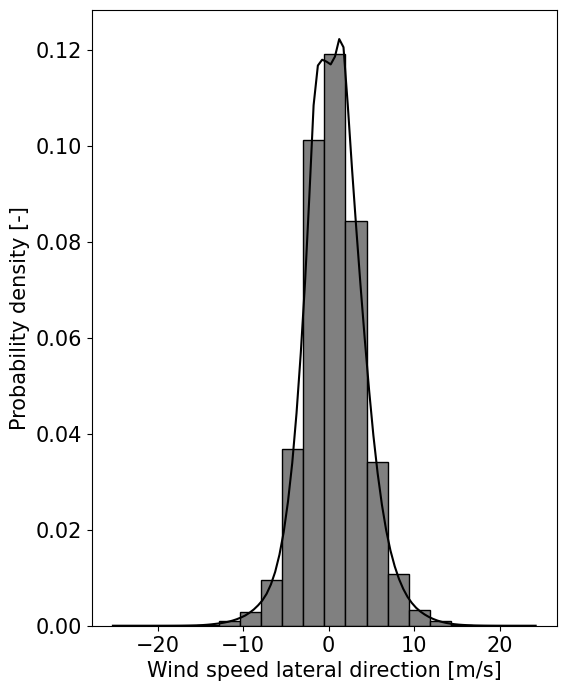

In [154]:
v10 = data_era5[:,2*1498:].flatten()
kde = gaussian_kde(v10)
x_values = np.linspace(min(v10), max(v10), 100)
pdf_values = kde(x_values)

plt.figure(figsize=(6,8))
plt.hist(v10, color="grey", edgecolor="k", bins=20, density=True)
plt.plot(x_values, pdf_values, color="k")
plt.xlabel("Wind speed lateral direction [m/s]", fontsize=15)
plt.ylabel("Probability density [-]", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()